In [ ]:
pip install tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# RNN model
# possible source: https://zhuanlan.zhihu.com/p/31656392
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers


from keras.datasets import imdb
from keras.layers import GRU, LSTM, CuDNNGRU, CuDNNLSTM, Activation, Input, concatenate, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

maxlen = 207

X_test_pre = np.load('/test_pre_sentences.npy')
X_test_hyp = np.load('/test_hyp_sentences.npy')
y_test = np.load('/test_label.npy')
y_test = y_test[np.newaxis].T

X_train_pre = np.load('/training_pre_sentences.npy')
X_train_hyp = np.load('/training_hyp_sentences.npy')
y_train = np.load('/training_label.npy')
y_train = y_train[np.newaxis].T

# pad the sequences with zeros 
# padding parameter is set to 'post' => 0's are appended to end of sequences
X_train_pre = pad_sequences(X_train_pre, maxlen = maxlen, padding = 'post')
X_train_hyp = pad_sequences(X_train_hyp, maxlen = maxlen, padding = 'post')
X_test_pre = pad_sequences(X_test_pre, maxlen = maxlen, padding = 'post')


2.5.0
(2945, 207)
(2945, 1)
(6870, 207)
(6870, 207)
(6870, 1)
(2945, 207)


# New Section

In [ ]:
dim_2 = X_train_pre.shape[1]

# convert numpy arrays into tensors
input_A = Input(shape = (dim_2, ))
input_B = Input(shape = (dim_2, ))

# embeddings
embedding = Embedding(491, 100, trainable=False)

# for input_A
embedded_A = embedding(input_A)

# for input_B
embedded_B = embedding(input_B)

# pre
layer_1_pre = LSTM(50, return_sequences = True)(embedded_A)
dense_4 =Dense(25)(layer_1_pre)
model_1 = LSTM(20, return_sequences = False)(dense_4)


# hyp
layer_1_hyp = LSTM(50, return_sequences = True)(embedded_B)
dense_3 = Dense(25)(layer_1_hyp)
model_2 = LSTM(20, return_sequences = False)(dense_3)

# combine output of model for each sentence of the pairing
combined = concatenate([model_1, model_2]) # dim  from 20 -> 40
# Dense layers
dense_1 = Dense(25)(combined)
act_1 = Activation('sigmoid')(dense_1)
output = Dense(1)(act_1)
z = Activation('sigmoid')(output)
print(z.shape)

model = Model(inputs=[input_A, input_B], outputs=z)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

207
(None, 207)
(None, 207)
embedded pre (None, 207, 100)
embedded pre (None, 207, 100)
(None, 1)


In [ ]:
%%time
history = model.fit([X_train_pre, X_train_hyp], y_train, batch_size = 100, epochs = 100, verbose = 1)

Epoch 1/100
69/69 [==============================] - 31s 444ms/step - loss: 0.1059 - accuracy: 0.3153
Epoch 2/100
69/69 [==============================] - 31s 444ms/step - loss: 0.1053 - accuracy: 0.3153
Epoch 3/100
69/69 [==============================] - 31s 444ms/step - loss: 0.1055 - accuracy: 0.3153
Epoch 4/100
69/69 [==============================] - 31s 444ms/step - loss: 0.1054 - accuracy: 0.3153
Epoch 5/100
69/69 [==============================] - 31s 447ms/step - loss: 0.1060 - accuracy: 0.3153
Epoch 6/100
69/69 [==============================] - 31s 445ms/step - loss: 0.1059 - accuracy: 0.3153
Epoch 7/100
69/69 [==============================] - 31s 443ms/step - loss: 0.1060 - accuracy: 0.3153
Epoch 8/100
69/69 [==============================] - 31s 443ms/step - loss: 0.1058 - accuracy: 0.3153
Epoch 9/100
69/69 [==============================] - 31s 445ms/step - loss: 0.1055 - accuracy: 0.3153
Epoch 10/100
69/69 [==============================] - 31s 444ms/step - loss: 0.105

In [ ]:
# accuracy test
scores = model.evaluate([X_test_pre,X_test_hyp], y_test, verbose=1)
print(scores)
print("Accuracy: %.2f%%" % (scores[1]*100))

93/93 [==============================] - 6s 64ms/step - loss: 0.0219 - accuracy: 1.0000
[0.021909447386860847, 1.0]
Accuracy: 100.00%


Text(0.5, 1.0, 'Loss and Accuracy Per Epoch')

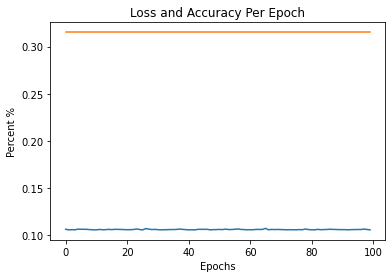

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('Epochs')
plt.ylabel('Percent %')
plt.title('Loss and Accuracy Per Epoch')

(6870, 207)


(array([   0.,    0., 2945.,    0.]),
 array([0.5 , 0.75, 1.  , 1.25, 1.5 ]),
 <a list of 4 Patch objects>)

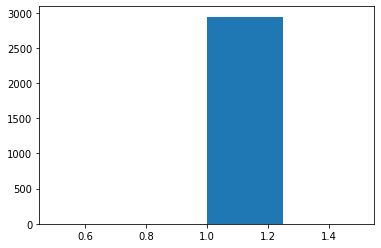

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test, bins=4)